In this notebook we tried to predcit the Critical Risk column which were predominantly 'Others'. We have performed model train and test on augmented data due to very small dataset.

Pickle from the best performing model is used for final model pipeline.

# Load Libraries

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting the current working directory
import os; os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')

In [ ]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords
from text_preprocess import * #(custom module)

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

!rm -R log/

#Lable Encoder to change the categorical values to numerical values.
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

rm: cannot remove 'log/': No such file or directory


# Load Data

## Load augmented data
* This is augmented due to limited dataset which was provided.

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset_Aug.csv')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/cat_train.csv')
#val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/cat_val.csv')
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data)

Data has 469 rows and 11 columns. Here are the first five rows of the data...


,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,14,2/4/2016 0:00,Country_02,Local_05,Metals,I,III,Male,Employee,Confined space,Due to the accumulation of Waelz on the convey...
1,91,3/24/2016 0:00,Country_03,Local_10,Others,IV,IV,Male,Third Party,Poll,"When performing the sleeve removal maneuver, w..."
2,191,7/21/2016 0:00,Country_02,Local_12,Others,I,II,Female,Employee,Traffic,"At the EusÃ©bio bridge, there was a sudden bra..."
3,266,11/13/2016 0:00,Country_01,Local_06,Metals,I,II,Male,Employee,Plates,"Being the 01:30 hrs, After the cathode goes th..."
4,305,1/8/2017 0:00,Country_02,Local_05,Metals,II,IV,Male,Employee,Projection/Burning,Employee performed withdrawal of electrical fa...
...,...,...,...,...,...,...,...,...,...,...,...
464,408,5/18/2017 0:00,Country_01,Local_06,Metals,IV,IV,Male,Third Party,Pressed,Being 10:20 hours on 05/18/2017; At the end of...
465,418,6/11/2017 0:00,Country_01,Local_04,Mining,I,II,Male,Employee,Pressed,In circumstances where the worker and two part...
466,421,6/14/2017 0:00,Country_02,Local_02,Mining,III,IV,Male,Third Party (Remote),Pressed,The employee performed insertion and adjustmen...
467,433,6/29/2017 0:00,Country_02,Local_02,Mining,I,III,Male,Employee,Pressed,After maintenance on Boltec 03 at level 285 GT...


In [ ]:
data_bkp = data.copy()

In [ ]:
print('Dropping Unnamed: 0 column')
data.drop(['Unnamed: 0'],axis =1,inplace = True)

Dropping Unnamed: 0 column


In [ ]:
print('Dropping duplicates')
#data.drop_duplicates(inplace=True)

Dropping duplicates


In [ ]:
data.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
data['SNo']= data.index+1
_='''data['Date'] =  pd.to_datetime(data['Date'], infer_datetime_format=True)
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data['weekday'] = data['Date'].dt.day_name()
data.reset_index(inplace=True)
data.info()
'''

In [ ]:
data

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Critical Risk,Description,SNo
0,2/4/2016 0:00,Country_02,Local_05,Metals,I,III,Male,Employee,Confined space,Due to the accumulation of Waelz on the convey...,1
1,3/24/2016 0:00,Country_03,Local_10,Others,IV,IV,Male,Third Party,Poll,"When performing the sleeve removal maneuver, w...",2
2,7/21/2016 0:00,Country_02,Local_12,Others,I,II,Female,Employee,Traffic,"At the EusÃ©bio bridge, there was a sudden bra...",3
3,11/13/2016 0:00,Country_01,Local_06,Metals,I,II,Male,Employee,Plates,"Being the 01:30 hrs, After the cathode goes th...",4
4,1/8/2017 0:00,Country_02,Local_05,Metals,II,IV,Male,Employee,Projection/Burning,Employee performed withdrawal of electrical fa...,5
...,...,...,...,...,...,...,...,...,...,...,...
464,5/18/2017 0:00,Country_01,Local_06,Metals,IV,IV,Male,Third Party,Pressed,Being 10:20 hours on 05/18/2017; At the end of...,465
465,6/11/2017 0:00,Country_01,Local_04,Mining,I,II,Male,Employee,Pressed,In circumstances where the worker and two part...,466
466,6/14/2017 0:00,Country_02,Local_02,Mining,III,IV,Male,Third Party (Remote),Pressed,The employee performed insertion and adjustmen...,467
467,6/29/2017 0:00,Country_02,Local_02,Mining,I,III,Male,Employee,Pressed,After maintenance on Boltec 03 at level 285 GT...,468


In [ ]:
from text_preprocess import * #(custom module)
import re
def clean_text(df, col):
	print('--'*30); print('Converting headlines to lower case')
	new_col_name = "cleaned_" + str(col)
	print(new_col_name)
	df.new_col_name = df[col].apply(lambda x : x.lower())
	print(df.new_col_name[0])

	print('Replacing apostrophes to the standard lexicons')
	df.new_col_name = df.new_col_name.apply(lambda x : replace_words(x))

	print('Removing punctuations')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_punctuation(x))

	print('Removing Numbers')
	df.new_col_name = df.new_col_name.apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

	print('Applying Lemmatizer')
	df.new_col_name = df.new_col_name.apply(lambda x: lem(x))

	print('Removing multiple spaces between words')
	df.new_col_name = df.new_col_name.apply(lambda x: re.sub(' +', ' ', x))

	print('Removing stopwords')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_stopwords(x))

	# remove short words (length < 3)
	print('Removing short words')
	df.new_col_name = df.new_col_name.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
	print('--'*30)
	return(df.new_col_name)

In [ ]:
risk_map = {'\nNot applicable': 99,
'Bees': 1,
'Venomous Animals': 1,
'Blocking and isolation of energies': 3,
'Burn': 3,
'Confined space': 3,
'Cut': 3,
'Machine Protection': 3,
'Manual Tools': 3,
'Poll': 3,
'Projection': 3,
'Projection of fragments': 3,
'Projection/Burning': 3,
'Projection/Choco': 3,
'Projection/Manual Tools': 3,
'remains of choco': 3,
'Suspended Loads': 3,
'Fall': 4,
'Fall prevention': 4,
'Fall prevention (same level)': 4,
'Electrical installation': 5,
'Electrical Shock': 5,
'Plates': 5,
'Power lock': 5,
'Chemical substances': 6,
'Liquid Metal': 7,
'Pressed': 8,
'Pressurized Systems': 8,
'Pressurized Systems / Chemical Substances': 8,
'Individual protection equipment': 9,
'Traffic': 10,
'Vehicles and Mobile Equipment': 11,
'Others': 99}
data['Critical Risk'] = pd.Series([risk_map[x] for x in data['Critical Risk']], index=data.index)

### Description Clean up

In [ ]:
data = data[['SNo','Description','Critical Risk']]

In [ ]:
data['cleaned_Description'] = clean_text(data,"Description")

------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
due to the accumulation of waelz on the conveyor and trailer of the filter 08fi0502, the employee performed the cleaning of the shutter using the air lance, when he was surprised by the fall of the product that was above the door, passing between the neck and the collar of the aramid jacket and causing burn in the neck and shoulder.
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


In [ ]:
data

,SNo,Description,Critical Risk,cleaned_Description
0,1,Due to the accumulation of Waelz on the convey...,3,due accumulation waelz conveyor trailer filter...
1,2,"When performing the sleeve removal maneuver, w...",3,performing sleeve removal maneuver hole meter ...
2,3,"At the EusÃ©bio bridge, there was a sudden bra...",10,eusã©bio bridge sudden braking several car bra...
3,4,"Being the 01:30 hrs, After the cathode goes th...",5,cathode pre estriping sheet detached bend cath...
4,5,Employee performed withdrawal of electrical fa...,3,employee performed withdrawal electrical failu...
...,...,...,...,...
464,465,Being 10:20 hours on 05/18/2017; At the end of...,8,hour end concentrate truck cleaning driver ins...
465,466,In circumstances where the worker and two part...,8,circumstance worker two partner placing killer...
466,467,The employee performed insertion and adjustmen...,8,employee performed insertion adjustment joint ...
467,468,After maintenance on Boltec 03 at level 285 GT...,8,maintenance boltec level gts rampa xxx mechani...


## Load augmented Val data
* This is augmented due to limited dataset which was provided.

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset_Aug.csv')

val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/cat_val.csv')
print(f'Data has {val.shape[0]} rows and {val.shape[1]} columns. Here are the first five rows of the data...')
display(val)

Data has 13 rows and 11 columns. Here are the first five rows of the data...


,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,13,2/2/2016 0:00,Country_01,Local_01,Mining,IV,V,Male,Third Party,Electrical installation,"In moments that the operator of the Jumbo 2, t..."
1,336,2/8/2017 0:00,Country_01,Local_06,Metals,I,III,Male,Employee,Machine Protection,"When averaging 04:30 am, the operator Daniel r..."
2,12,2/1/2016 0:00,Country_02,Local_05,Metals,I,I,Male,Employee,Liquid Metal,The collaborator reports that he was working i...
3,62,3/9/2016 0:00,Country_01,Local_06,Metals,I,IV,Male,Third Party,Suspended Loads,The operator was feeding a bag of big bag cont...
4,1,1/2/2016 0:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
5,323,1/29/2017 0:00,Country_01,Local_01,Mining,I,III,Male,Third Party,Vehicles and Mobile Equipment,In circumstances that the tipper MV-01 of the ...
6,137,5/24/2016 0:00,Country_03,Local_10,Others,IV,IV,Male,Third Party,Fall,"During field trip, to return to work after lun..."
7,141,5/25/2016 0:00,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,The ground team coordinated by Prospector with...
8,205,8/14/2016 0:00,Country_02,Local_08,Metals,I,III,Male,Employee,Projection,The employee Mr. Nilton made the opening of th...
9,106,4/17/2016 0:00,Country_02,Local_05,Metals,I,IV,Male,Employee,Cut,Employee reports that when attempting to manua...


In [ ]:
print('Dropping Unnamed: 0 column')
val.drop(['Unnamed: 0'],axis =1,inplace = True)

Dropping Unnamed: 0 column


In [ ]:
print('Dropping duplicates')
#data.drop_duplicates(inplace=True)

Dropping duplicates


In [ ]:
val.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
val['SNo']= val.index+1
_='''data['Date'] =  pd.to_datetime(data['Date'], infer_datetime_format=True)
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data['weekday'] = data['Date'].dt.day_name()
data.reset_index(inplace=True)
data.info()
'''

In [ ]:
val

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Critical Risk,Description,SNo
0,2/2/2016 0:00,Country_01,Local_01,Mining,IV,V,Male,Third Party,Electrical installation,"In moments that the operator of the Jumbo 2, t...",1
1,2/8/2017 0:00,Country_01,Local_06,Metals,I,III,Male,Employee,Machine Protection,"When averaging 04:30 am, the operator Daniel r...",2
2,2/1/2016 0:00,Country_02,Local_05,Metals,I,I,Male,Employee,Liquid Metal,The collaborator reports that he was working i...,3
3,3/9/2016 0:00,Country_01,Local_06,Metals,I,IV,Male,Third Party,Suspended Loads,The operator was feeding a bag of big bag cont...,4
4,1/2/2016 0:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,5
5,1/29/2017 0:00,Country_01,Local_01,Mining,I,III,Male,Third Party,Vehicles and Mobile Equipment,In circumstances that the tipper MV-01 of the ...,6
6,5/24/2016 0:00,Country_03,Local_10,Others,IV,IV,Male,Third Party,Fall,"During field trip, to return to work after lun...",7
7,5/25/2016 0:00,Country_03,Local_10,Others,I,I,Male,Third Party,Bees,The ground team coordinated by Prospector with...,8
8,8/14/2016 0:00,Country_02,Local_08,Metals,I,III,Male,Employee,Projection,The employee Mr. Nilton made the opening of th...,9
9,4/17/2016 0:00,Country_02,Local_05,Metals,I,IV,Male,Employee,Cut,Employee reports that when attempting to manua...,10


In [ ]:
val['Critical Risk'] = pd.Series([risk_map[x] for x in val['Critical Risk']], index=val.index)

In [ ]:
data_val = val[['SNo','Description','Critical Risk']]

In [ ]:
data_val

,SNo,Description,Critical Risk
0,1,"In moments that the operator of the Jumbo 2, t...",5
1,2,"When averaging 04:30 am, the operator Daniel r...",3
2,3,The collaborator reports that he was working i...,7
3,4,The operator was feeding a bag of big bag cont...,3
4,5,During the activation of a sodium sulphide pum...,8
5,6,In circumstances that the tipper MV-01 of the ...,11
6,7,"During field trip, to return to work after lun...",4
7,8,The ground team coordinated by Prospector with...,1
8,9,The employee Mr. Nilton made the opening of th...,3
9,10,Employee reports that when attempting to manua...,3


In [ ]:
data_val['cleaned_Description'] = clean_text(data_val,"Description")

------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
in moments that the operator of the jumbo 2, tried energize your equipment to proceed to the installation of 4 split set at intersection 544 of nv 3300, remove the lock and opening the electric board of 440v and 400a, and when lifting the thermomagnetic key this makes phase to ground - phase contact with the panel shell - producing a flash which reaches the operator causing the injury described.
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


### Description Clean up

In [ ]:
data

,SNo,Description,Critical Risk,cleaned_Description
0,1,Due to the accumulation of Waelz on the convey...,3,due accumulation waelz conveyor trailer filter...
1,2,"When performing the sleeve removal maneuver, w...",3,performing sleeve removal maneuver hole meter ...
2,3,"At the EusÃ©bio bridge, there was a sudden bra...",10,eusã©bio bridge sudden braking several car bra...
3,4,"Being the 01:30 hrs, After the cathode goes th...",5,cathode pre estriping sheet detached bend cath...
4,5,Employee performed withdrawal of electrical fa...,3,employee performed withdrawal electrical failu...
...,...,...,...,...
464,465,Being 10:20 hours on 05/18/2017; At the end of...,8,hour end concentrate truck cleaning driver ins...
465,466,In circumstances where the worker and two part...,8,circumstance worker two partner placing killer...
466,467,The employee performed insertion and adjustmen...,8,employee performed insertion adjustment joint ...
467,468,After maintenance on Boltec 03 at level 285 GT...,8,maintenance boltec level gts rampa xxx mechani...


In [ ]:
data_val

,SNo,Description,Critical Risk,cleaned_Description
0,1,"In moments that the operator of the Jumbo 2, t...",5,moment operator jumbo tried energize equipment...
1,2,"When averaging 04:30 am, the operator Daniel r...",3,averaging operator daniel removed cleaning acc...
2,3,The collaborator reports that he was working i...,7,collaborator report working ustulaciãn realize...
3,4,The operator was feeding a bag of big bag cont...,3,operator feeding bag big bag containing scrap ...
4,5,During the activation of a sodium sulphide pum...,8,activation sodium sulphide pump piping uncoupl...
5,6,In circumstances that the tipper MV-01 of the ...,11,circumstance tipper mceisa moved operator see ...
6,7,"During field trip, to return to work after lun...",4,field trip return work lunch employee wellfiel...
7,8,The ground team coordinated by Prospector with...,1,ground team coordinated prospector assistant s...
8,9,The employee Mr. Nilton made the opening of th...,3,employee nilton made opening visit unclog mome...
9,10,Employee reports that when attempting to manua...,3,employee report attempting manually ingot zinc...


## Load actual data to prepare our final dataset
* Based on actual file provided

In [ ]:
risk_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv')
risk_data_df.drop(['Unnamed: 0'],axis =1,inplace = True)
risk_data_df.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
risk_data_df['Critical Risk'] = pd.Series([risk_map[x] for x in risk_data_df['Critical Risk']], index=risk_data_df.index)

# Others
without_risk_df = risk_data_df[risk_data_df['Critical Risk'] == 99].reset_index(drop=True)

# Non-others where actual data was provided
with_risk_df = risk_data_df[risk_data_df['Critical Risk'] != 99].reset_index(drop=True)

#with_risk_df.drop(columns = 'Critical_Risk',axis= 1, inplace=True)

In [ ]:
without_risk_df = without_risk_df[without_risk_df['Critical Risk'] == 99].reset_index(drop=True)
without_risk_df.drop(columns=['Critical Risk'],axis=1,inplace=True)

### Description Clean up

In [ ]:
without_risk_df['cleaned_Description'] = clean_text(without_risk_df,"Description")

------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
being 9:45 am. approximately in the nv. 1880 cx-695 ob7, the personnel begins the task of unlocking the soquet bolts of the bhb machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding mr. cristóbal - auxiliary assistant to climb to the platform to exert pressure with your hand on the "dado" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


## Calculate words and line size on cleaned text

In [ ]:
# Get length of each line
data['line_length'] = data['cleaned_Description'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))

Minimum line length: 64
Maximum line length: 634


In [ ]:
# Get length of each line
data['nb_words'] = data['cleaned_Description'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))

Minimum number of words: 10
Maximum number of words: 93


## Others and Non-other category wise data split

In [ ]:
#Test = data[data['Critical Risk'] == 99].reset_index(drop=True)
Train = data[data['Critical Risk'] != 99].reset_index(drop=True)

In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SNo                  468 non-null    int64 
 1   Description          468 non-null    object
 2   Critical Risk        468 non-null    int64 
 3   cleaned_Description  468 non-null    object
 4   line_length          468 non-null    int64 
 5   nb_words             468 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 22.1+ KB


In [ ]:
Train.head()

,SNo,Description,Critical Risk,cleaned_Description,line_length,nb_words
0,1,Due to the accumulation of Waelz on the convey...,3,due accumulation waelz conveyor trailer filter...,187,26
1,2,"When performing the sleeve removal maneuver, w...",3,performing sleeve removal maneuver hole meter ...,634,93
2,3,"At the EusÃ©bio bridge, there was a sudden bra...",10,eusã©bio bridge sudden braking several car bra...,119,18
3,4,"Being the 01:30 hrs, After the cathode goes th...",5,cathode pre estriping sheet detached bend cath...,268,36
4,5,Employee performed withdrawal of electrical fa...,3,employee performed withdrawal electrical failu...,199,27


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    Train['cleaned_Description'].values, Train['Critical Risk'].values, 
    test_size=0.1, random_state=0)
print('Training utterances: {}'.format(X_train.shape[0]))
print('Validation utterances: {}'.format(X_val.shape[0]))

#X_predict =without_risk_df['cleaned_Description'].values

Training utterances: 421
Validation utterances: 47


# Tokenizer and word embeddings

In [ ]:
max_features = 1000
maxlen = 100 #max(data.nb_words)
#embedding_size = 200

In [ ]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(X_train))
tokenizer.fit_on_texts(list(X_val))
tokenizer.fit_on_texts(list(X_val))


In [ ]:
maxlen

100

## Text Train split

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = maxlen)
#y_Train = np.asarray(Train['Critical_Risk'])

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen = maxlen)


print(f'Number of Samples: {len(X_train)}')
print(f'Number of Labels: {len(y_train)}')
print(f'\nFirst Description:\n{X_train[0]}\n\nLabel of the first description: {y_train[0]}')

print(f'Number of Samples: {len(X_val)}')
print(f'Number of Labels: {len(y_val)}')
print(f'\nFirst Description:\n{X_val[0]}\n\nLabel of the first description: {y_val[0]}')

Number of Samples: 421
Number of Labels: 421

First Description:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  56  67
 618  73   8 217 217 157   5  31   7   6]

Label of the first description: 3
Number of Samples: 47
Number of Labels: 47

First Description:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  34 118 434 826 431  88   9 269   3
  18  12 398 646 827  20  19 499 577 334 828  50 829  98 484 289  13 830
 831 118 155 491 832 118 833   9   3  18  75   7  18  12  97   9 834 237
 485 194 203 446 191 482   9  13 835 836 233   3 435 837 407 112 257 838
 690  26 122 497 203 839  10 111 840 606]

Label of the first des

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(421, 100)
(421,)
(47, 100)
(47,)


In [ ]:
X_train

array([[  0,   0,   0, ...,  31,   7,   6],
       [  0,   0,   0, ..., 364,   3,   6],
       [  0,   0,   0, ..., 138,  43,  14],
       ...,
       [  0,   0,   0, ..., 305, 204, 472],
       [  0,   0,   0, ..., 138,  43,  14],
       [  0,   0,   0, ..., 286, 377,   7]], dtype=int32)

In [ ]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


seed=42
pipe_steps = [ ('sc' , StandardScaler()),
    ('pca', PCA())]

check_params= {
    'pca__n_components': [45] 
   # 'RF__max_depth': [18,20,22]
    #'RF__n_estimators' :[300,500,900],
    #'RF__max_features' : [5,6],
    #'RF__ccp_alpha' : [0.05,0.1]
}
pca_pipeline = Pipeline(pipe_steps)

In [ ]:
dump(scaler, open('scaler.pkl', 'wb'))

BR: 0.881373 (0.038488)
XGB: 0.871961 (0.053019)
RF: 0.905154 (0.041255)
CART: 0.902801 (0.041385)
GB: 0.886134 (0.043682)
SVM: 0.632017 (0.063866)


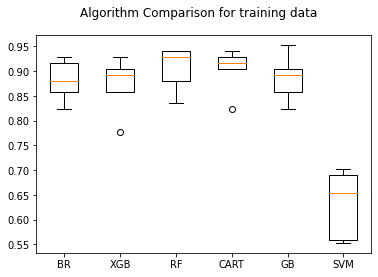

In [ ]:
# Compare Algorithms for full data
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb


x_train_tr=pca_pipeline.fit_transform(X_train)
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('BR', BaggingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('SVM', SVC(kernel='rbf')))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, x_train_tr, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison for training data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Standard scalar

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

## PCA

In [ ]:
# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

Components_Number = 45

pca = PCA(n_components = Components_Number , random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_val_pca = pca.transform(X_val_sc)
display(X_train_pca.shape, X_val_pca.shape)
feature = X_train_pca.shape[1]
pca_s = sum(pca.explained_variance_ratio_)*100
print(f'Explained Variance: {pca_s:1.3f}% with {feature} features.')

(421, 45)

(47, 45)

Explained Variance: 99.288% with 45 features.


# Performnce Tuning

In [ ]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# define dataset

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
rf_grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0,verbose=2)
grid_result = rf_grid_search.fit(X_train_pca, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Fitting 30 folds for each of 6 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.9min finished


Best: 0.935788 using {'max_features': 'log2', 'n_estimators': 1000}
0.912828 (0.043169) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.931026 (0.038606) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.935788 (0.033793) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.912791 (0.041945) with: {'max_features': 'log2', 'n_estimators': 10}
0.935013 (0.034202) with: {'max_features': 'log2', 'n_estimators': 100}
0.935788 (0.034348) with: {'max_features': 'log2', 'n_estimators': 1000}


In [ ]:
print('RF accuracy for test set: {0:.3f}'.format(rf_grid_search.score(X_val_pca, y_val)))

RF accuracy for test set: 0.979


In [ ]:
X_Test

array([[  0,   0,   0, ...,   5,  30, 221],
       [  0,   0,   0, ..., 192,  24, 297],
       [  0,   0,   0, ..., 220, 125,   7],
       ...,
       [  0,   0,   0, ..., 104,  24,  61],
       [  0,   0,   0, ...,  10,   5,  30],
       [  0,   0,   0, ..., 332, 423, 834]], dtype=int32)

# Validation/Test with augmented dataset

In [ ]:
# get prediction  column cleaned data
X_Test =data_val['cleaned_Description'].values
y_Test =data_val['Critical Risk'].values
#tokenize
tokenizer.fit_on_texts(list(X_Test))
# to sequences
X_Test = tokenizer.texts_to_sequences(X_Test)
X_Test = pad_sequences(X_Test, maxlen = maxlen)


# scalar
X_Test_sc = sc.transform(X_Test)
# pca
X_Test_pca = pca.transform(X_Test_sc)

# Predict
#y_pred = svc_grid.predict(X_Test_pca)

# Accuracy Score
#print('Accuracy Score on Test: {}'.format(accuracy_score(y_Test, y_pred).round(3)))

In [ ]:
#Random forest
# Predict
y_pred = rf_grid_search.predict(X_Test_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_Test, y_pred).round(3)))

Accuracy Score on Test: 0.462


In [ ]:
y_Test

array([ 5,  3,  7,  3,  8, 11,  4,  1,  3,  3,  6,  3,  8])

In [ ]:
miport pickle
filename = 'predict_risk.pkl'
pickle.dump(rf_grid_search, open(filename, 'wb'))

In [ ]:
# get prediction  column cleaned data
X_Test =data_val['cleaned_Description'].values
y_Test =data_val['Critical Risk'].values
#tokenize
tokenizer.fit_on_texts(list(X_Test))
# to sequences
X_Test = tokenizer.texts_to_sequences(X_Test)
X_Test = pad_sequences(X_Test, maxlen = maxlen)


# scalar
X_Test_sc = sc.transform(X_Test)
# pca
X_Test_pca = pca.transform(X_Test_sc)


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)
result = loaded_model.predict(X_Test_pca[[1]])
print(result) 

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)
[3]


In [ ]:
X_Test_pca[:1]

array([[-0.17587299,  0.18951957, -0.42159317, -1.59150953,  1.24714621,
         0.53034851,  1.87947179, -1.61754682, -0.60433885,  0.20556162,
        -0.38906604, -1.32082614,  0.95217881, -2.07306187,  1.43420493,
         0.162665  ,  0.48953012,  0.42499615,  0.24705881,  1.29113587,
         0.9040456 ,  0.71473101,  0.91861921,  0.0445115 ,  0.10123446,
        -0.53648493,  2.66275315, -2.01270374,  2.50031433,  1.56955347,
        -1.99581212,  1.55226178,  1.09388991, -2.00459582,  1.81515043,
        -1.02134841,  1.1868653 , -2.43994481,  4.45155453, -1.78563532,
        -0.65386347,  1.41833287, -0.8143757 ,  5.29211391,  0.16254654]])

In [ ]:
from sklearn.externals import joblib
filename = 'finalized_model_joblib.sav'
joblib.dump(svc_pca, filename)

['finalized_model_joblib.sav']

In [ ]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.734375


In [ ]:
without_risk_df

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Description
0,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Being 9:45 am. approximately in the Nv. 1880 C...
1,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Approximately at 11:45 a.m. in circumstances t...
2,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Employee was sitting in the resting area at le...
3,2016-01-28 00:00:00,Country_01,Local_03,Mining,I,III,Male,Employee,While installing a segment of the polyurethane...
4,2016-01-30 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,While preparing the rice for the lunch of the ...
...,...,...,...,...,...,...,...,...,...
228,2017-06-23 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,Employee reports that by removing the zinc she...
229,2017-06-19 00:00:00,Country_03,Local_10,Others,III,IV,Male,Third Party,During the execution of the task of assembling...
230,2017-06-22 00:00:00,Country_03,Local_10,Others,I,IV,Male,Employee,The technician was returning from his activiti...
231,2017-07-04 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,"Being approximately 5:00 a.m. approximately, w..."


# Predict risk where risk category was Others

In [ ]:
# get prediction  column cleaned data
X_predict =without_risk_df['cleaned_Description'].values
#tokenize
tokenizer.fit_on_texts(list(X_predict))
# to sequences
X_predict = tokenizer.texts_to_sequences(X_predict)
X_predict = pad_sequences(X_predict, maxlen = maxlen)

In [ ]:
# scalar
X_predict_sc = sc.transform(X_predict)
# pca
X_predict_pca = pca.transform(X_predict_sc)

In [ ]:
# Predict
y_pred = grid_search.predict(X_predict_pca)

# Accuracy Score
#print('Accuracy Score on Test: {}'.format(accuracy_score(y_test, y_pred).round(3)))

NameError: ignored

In [ ]:
pd.DataFrame(y_pred).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       233 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


In [ ]:
y_pred

array([ 3, 11,  8,  3,  3, 11,  3,  3,  3,  5,  3,  3,  3,  3,  3,  4,  8,
        3,  3,  3,  3,  3,  6,  3,  3,  3,  1,  3,  8,  3,  3,  3,  4,  1,
        5,  3,  3,  3,  3,  3,  3,  1,  3,  4,  1, 11,  3,  3, 11,  1,  3,
        5,  5,  3,  3,  3,  3,  3,  1,  1,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  1,  1,  3,  8,  4,  3,  1,  3, 11, 11,  8,  1,  3,  3,  4,  1,
        3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  3,  8,  5,  3,  3,  3,  3,
        3,  3,  3,  4,  4, 11,  3,  3,  1,  1,  1,  3,  3,  3,  3,  3,  3,
       11, 11,  3,  1, 11,  4,  3,  3,  1,  3,  3,  3,  8,  3,  3,  3,  3,
        3,  3,  3,  3,  8,  3,  3,  3, 11,  1,  4,  3,  4,  3,  3,  3,  8,
        1, 11,  3,  3, 11,  3,  3,  3,  1,  1,  8,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  8,  6,  3,  8,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  8,  1,  3,  6,
        8,  3, 11,  3,  3,  4,  8,  1,  3,  1,  3,  3,  8,  3,  1,  8,  3,
        3,  8,  8,  1,  3

# Concat predcted risk with the original dataframe 'Others' risk category

In [ ]:
without_risk_df['Critical Risk']= y_pred

In [ ]:
without_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date                 233 non-null    object
 1   Countries            233 non-null    object
 2   Local                233 non-null    object
 3   Industry             233 non-null    object
 4   Accident             233 non-null    object
 5   Potential_Accident   233 non-null    object
 6   Gender               233 non-null    object
 7   Emp_Type             233 non-null    object
 8   Description          233 non-null    object
 9   cleaned_Description  233 non-null    object
 10  Critical Risk        233 non-null    int64 
dtypes: int64(1), object(10)
memory usage: 20.1+ KB


In [ ]:
without_risk_df.drop(columns=['cleaned_Description'],axis=1,inplace=True)
without_risk_df

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Description,Critical Risk
0,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Being 9:45 am. approximately in the Nv. 1880 C...,3
1,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Approximately at 11:45 a.m. in circumstances t...,11
2,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Employee was sitting in the resting area at le...,8
3,2016-01-28 00:00:00,Country_01,Local_03,Mining,I,III,Male,Employee,While installing a segment of the polyurethane...,3
4,2016-01-30 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,While preparing the rice for the lunch of the ...,3
...,...,...,...,...,...,...,...,...,...,...
228,2017-06-23 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,Employee reports that by removing the zinc she...,3
229,2017-06-19 00:00:00,Country_03,Local_10,Others,III,IV,Male,Third Party,During the execution of the task of assembling...,3
230,2017-06-22 00:00:00,Country_03,Local_10,Others,I,IV,Male,Employee,The technician was returning from his activiti...,3
231,2017-07-04 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,"Being approximately 5:00 a.m. approximately, w...",6


In [ ]:
with_risk_df

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,8,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,8,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),3,In the sub-station MILPO located at level +170...
3,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),8,During the unloading operation of the ustulado...
4,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,4,The collaborator reports that he was on street...
...,...,...,...,...,...,...,...,...,...,...
187,2017-06-22 00:00:00,Country_03,Local_10,Others,I,I,Male,Employee,1,"During the field activity in the AMG project, ..."
188,2017-06-29 00:00:00,Country_02,Local_02,Mining,I,III,Male,Employee,8,After maintenance on Boltec 03 at level 285 GT...
189,2017-07-05 00:00:00,Country_02,Local_09,Metals,I,II,Male,Employee,1,During the environmental monitoring activity i...
190,2017-07-06 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,3,The Employee performed the activity of strippi...


# Append with and without dataframes

In [ ]:
final_capstone_dataset = with_risk_df.append(without_risk_df,ignore_index=True)

In [ ]:
final_capstone_dataset

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,8,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,8,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),3,In the sub-station MILPO located at level +170...
3,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),8,During the unloading operation of the ustulado...
4,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,4,The collaborator reports that he was on street...
...,...,...,...,...,...,...,...,...,...,...
420,2017-06-23 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,3,Employee reports that by removing the zinc she...
421,2017-06-19 00:00:00,Country_03,Local_10,Others,III,IV,Male,Third Party,3,During the execution of the task of assembling...
422,2017-06-22 00:00:00,Country_03,Local_10,Others,I,IV,Male,Employee,3,The technician was returning from his activiti...
423,2017-07-04 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,6,"Being approximately 5:00 a.m. approximately, w..."


# Export Final dataframe

In [ ]:
final_capstone_dataset.to_csv('./final_capstone_dataset.csv')